# SLT-CE-7: Mean Field Approximation

<p style="background-color:#adebad;">
In this coding exercise we will solve the 2D ising model (aka image riconstruction model) using mean field
approximation.
</p>

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt19_lecture06.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise10.pdf)

[3] [Tutorial](https://ml2.inf.ethz.ch/courses/slt/tutorials/Tutorial-mean-field-apx.pdf)

[4] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[5] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[6] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

<p style="background-color:#adebad;">
We will be using the Ising model from the coding exercise 2 for image denoising, also described in Series 10 [2]. Recall that the model orignates from section 8.3.3 of [5]. However, to approximate the inference we will apply mean field approximation and then compare it to the MCMC estimates.
</p>

## Setup

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import time

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

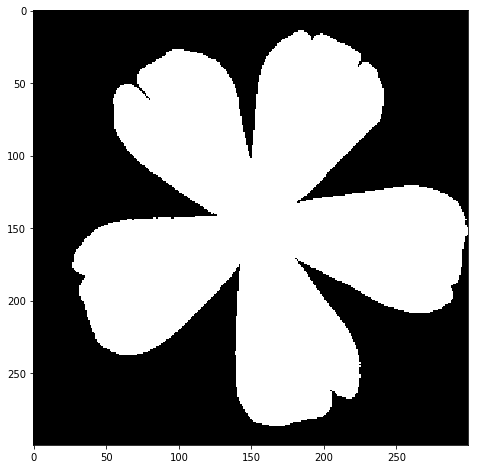

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [5]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

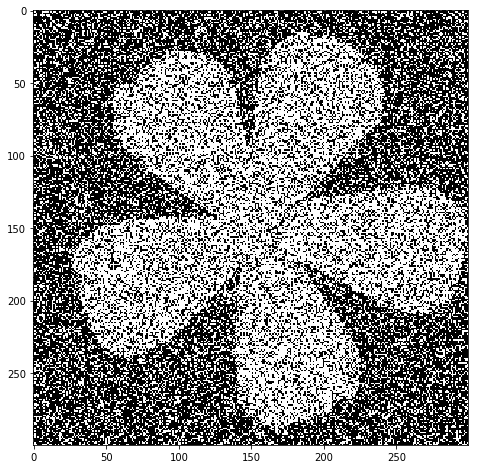

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as


In [7]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [8]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

In [9]:
energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION)

-300855.94

Estimating loss via mean squared error

In [10]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [11]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [12]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300855.94


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shorty describe the theory of the mean field approximation, you can choose to describe only one of the many derivation given in the tutorial [3] (e.g. variational upper bound).  
</p>


When we perform maximum entropy inference, we deal with the Gibbs distribution:
$$ p_\beta(c) = \frac{1}{Z(\beta)} \exp{(-\beta R(c))}, $$ 
where $Z(\beta)$ is the normalization factor which sums across all possible $c \in \mathcal C$. Often $|\mathcal C|$ is exponential and doing this way is computational infeasible. Therefore, to approximate the maximum entropy inference $\min_p G(p)$, where $G$ is the Gibbs free energy, we consider only the factorizable $p$ in the optimization, i.e. $\min_{p \in \text{'nice prob.'}} G(p)$, where
$p(c) = \prod_{i=1}^N p_i (c_i)$. Then, $Z(\beta)$ can be easily computed in polynomial time.

<p style="background-color:#adebad;">
With the help of [2], explain the algorithm for solving image denoising using mean field approximation:
</p>

The original Ising model is given as such:
$$ E(\sigma) = -\lambda \sum_{i=1}^N h_i \sigma_i - \sum_{i,j=1}^N J_{ij} \sigma_i \sigma_j, $$
where $h$ is the noisy image, $\sigma$ is the denoised image and $\lambda, J_{ij} \geq 0$ are some constants. By using mean field approximation, we can efficiently compute the parititon function $Z$ if we consider the energy function in the form of $E'(\sigma) = -\sum_{i=1}^N \sigma_i h'_i$, which gives the apprioximated denoised images $\sigma_k' = \tanh[\beta(\sum_{i\neq k} J_{ki}\sigma_i' + \lambda h_k)]$. We can then solve the problem by iteratively update all $\sigma'_i$s.

<p style="background-color:#adebad;">
Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the epochs parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.
Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Clearly explain the differences. Does it converge faster? What are the disadvantages and advantages?
Consider running the comparison on another image to prove your point.
Also, feel free to replace our implementation of MCMC with your own.
</p>

In [13]:
def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [14]:
def meanfield(img_noisy_observation, img_original, epochs, ti=0.01, tf=10, lamb=1, 
             kernel=np.array([[0, 1, 0], [1, 0 ,1], [0, 1, 0]])):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    
    img_estimate = img_noisy_observation.copy()
    
    # temperature from 10 to 0,1
    for temperature in np.linspace(tf, ti, epochs):
        for _ in range(50):
            Jm = convolve(img_estimate, kernel)
            img_estimate = np.tanh((Jm + lamb*img_noisy_observation) / temperature)
        E = energy(img_estimate, img_noisy_observation)
        L = mse_loss(img_estimate, img_original)
        energies.append(E)
        losses.append(L)
    return img_estimate, np.asarray(energies), np.asarray(losses)

In [15]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, **kwargs):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, **kwargs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

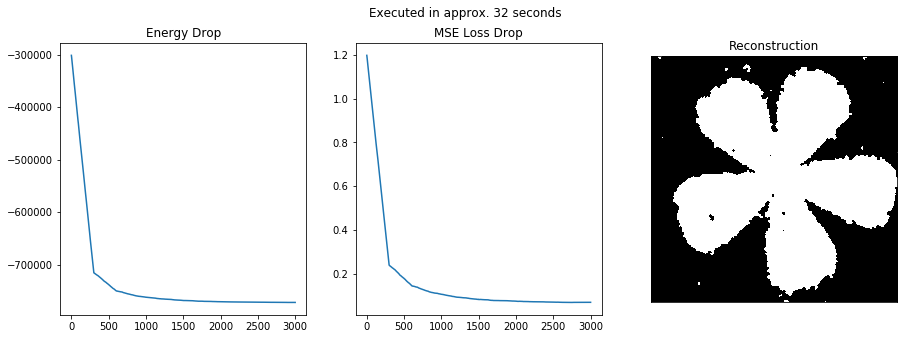

In [16]:
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

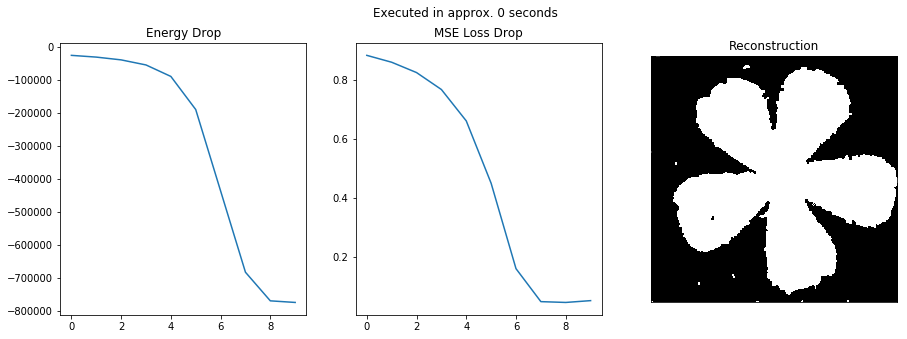

In [17]:
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

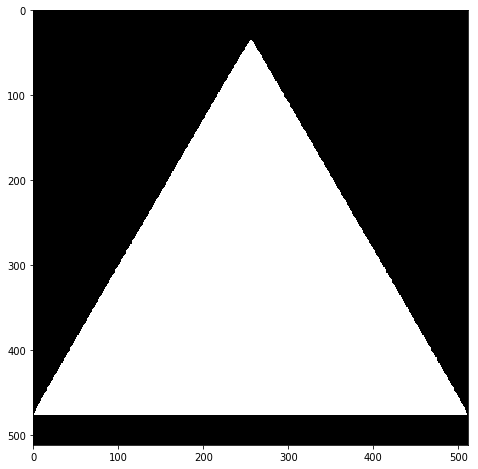

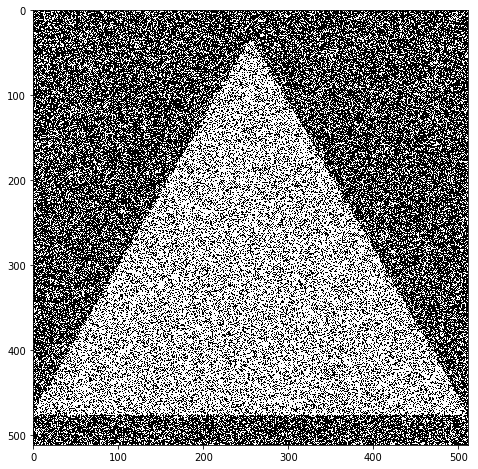

In [18]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

T_IMG_ORIGINAL = rgb2gray(mpimg.imread("triangle.png"))#[:,:,0]/255
T_IMG_ORIGINAL[T_IMG_ORIGINAL > 0.5] = 1
T_IMG_ORIGINAL[T_IMG_ORIGINAL <= 0.5] = -1

T_IMG_HEIGHT = T_IMG_ORIGINAL.shape[0]
T_IMG_WIDTH = T_IMG_ORIGINAL.shape[1]

# Fix random seed for reproducibility
np.random.seed(13)

T_IMG_NOISY_OBSERVATION = T_IMG_ORIGINAL.copy()
num_flips = int(0.3 * T_IMG_HEIGHT * T_IMG_WIDTH)

perm = np.random.permutation(T_IMG_ORIGINAL.size)[0:int(0.3 * T_IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/T_IMG_WIDTH)
    j = k%T_IMG_HEIGHT
    T_IMG_NOISY_OBSERVATION[i,j] = -T_IMG_NOISY_OBSERVATION[i,j]
    
plt.figure(figsize=(8,8))
plt.imshow(T_IMG_ORIGINAL, cmap='gray')

plt.figure(figsize=(8,8))
plt.imshow(T_IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

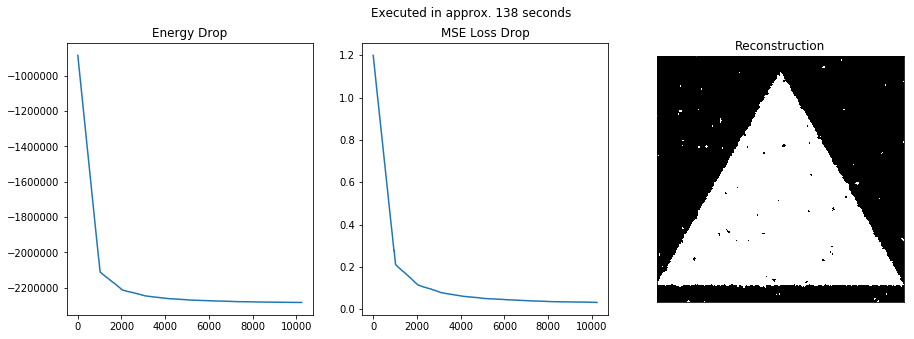

In [19]:
evaluate(metropolis, T_IMG_NOISY_OBSERVATION, T_IMG_ORIGINAL, 10)

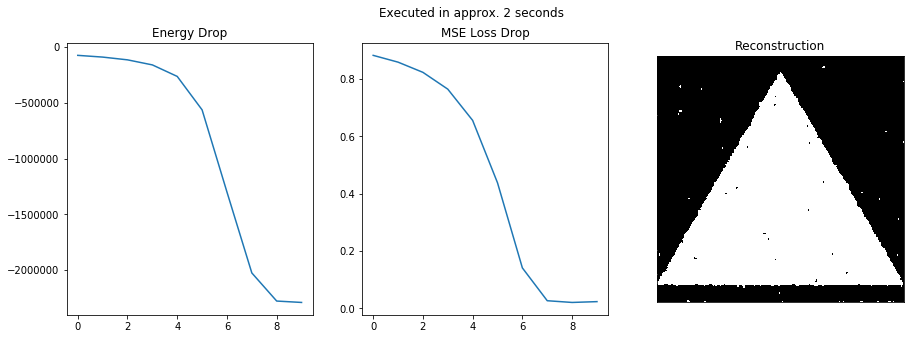

In [20]:
evaluate(meanfield, T_IMG_NOISY_OBSERVATION, T_IMG_ORIGINAL, 10)

<p style="background-color:#adebad;">
Compare and analyze performance
</p>

The mean-field approach can optimize the energy and MSE loss to lower values than metropolis can. The reconstructed image also look nicer and less influcenced by noise. The mean-field approach is also a lot faster.

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
Comment on the convergence of the method. How can we tell if the mean field convereged? Do we always reach the global optimum?
</p>

Meanfield converges slower than metropolis, but that is probably because of the high temperature that the algorithm is still 'exploring' different local minimums and does not stick to one early on. We can tell the mean field has converged when the graphs sort of flat-lined towards the end. We do not always reach the global optimium but it has a lesser chance of being stuck at a bad local optimum.

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
How do the parameters of the Ising model, and the tempereature affect the performance of the mean field?
Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. Can you explain the behaviour? Do you see a difference in the reconstraction at different temperature?
</p>

init temp:0.1, final temp:1, lambda:1, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


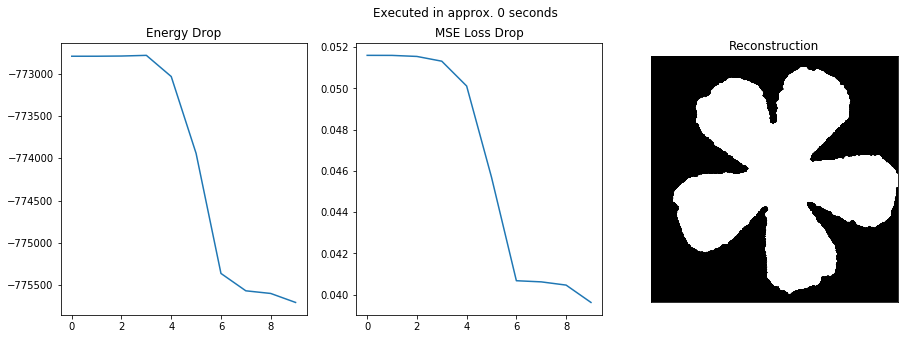

init temp:0.1, final temp:1, lambda:1, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


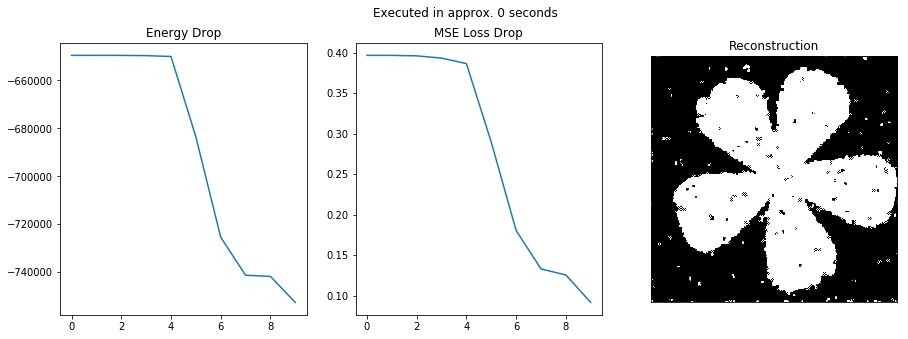

init temp:0.1, final temp:1, lambda:2, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


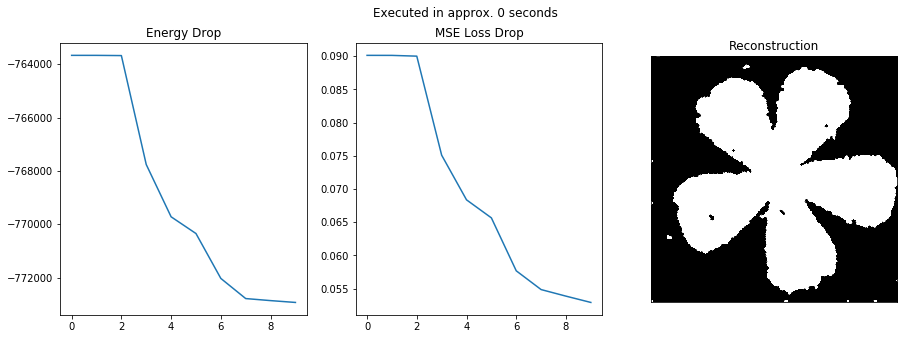

init temp:0.1, final temp:1, lambda:2, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


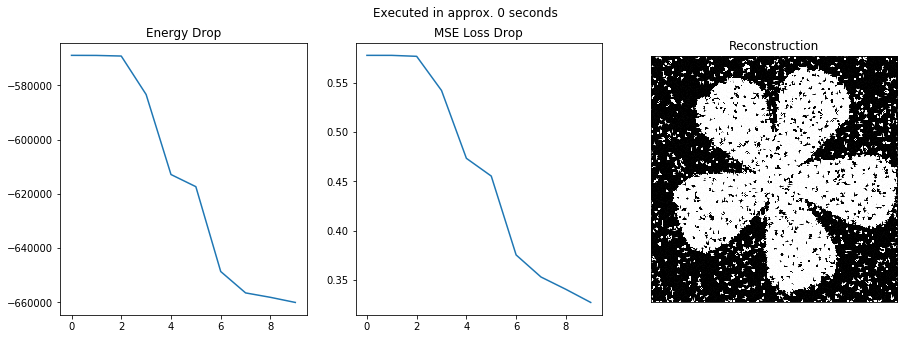

init temp:0.001, final temp:1, lambda:1, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


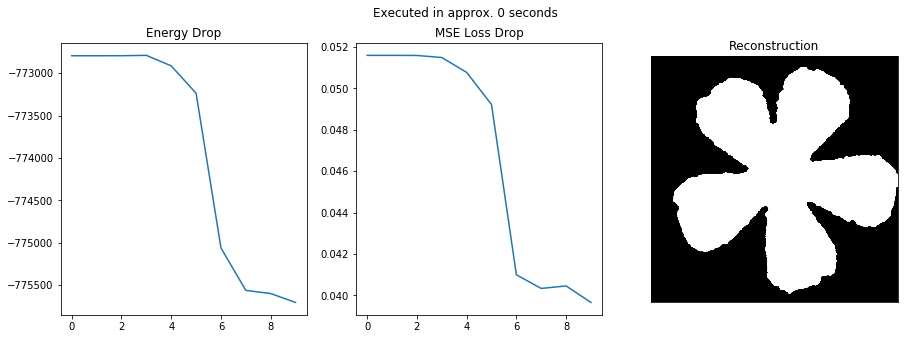

init temp:0.001, final temp:1, lambda:1, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


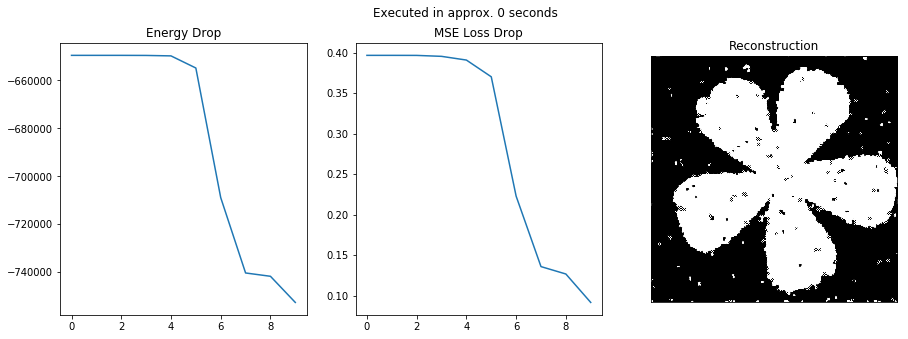

init temp:0.001, final temp:1, lambda:2, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


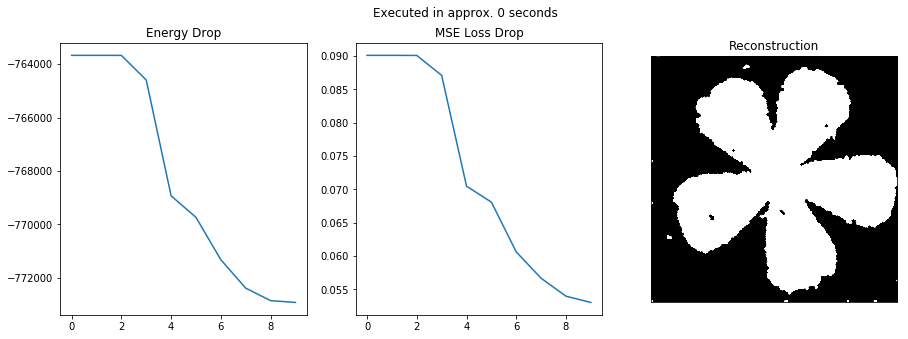

init temp:0.001, final temp:1, lambda:2, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


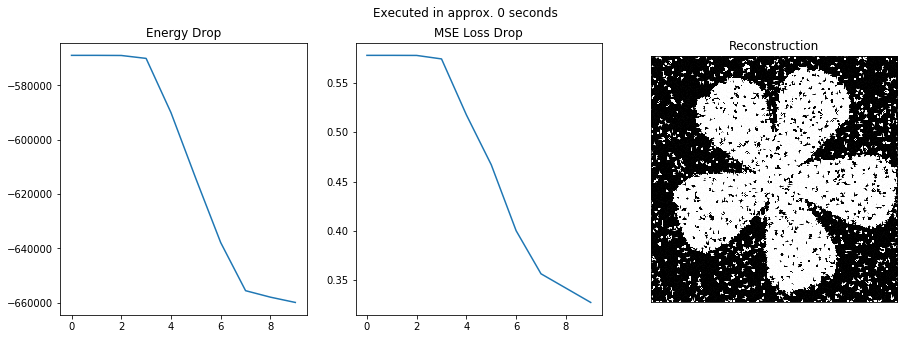

init temp:0.1, final temp:10, lambda:1, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


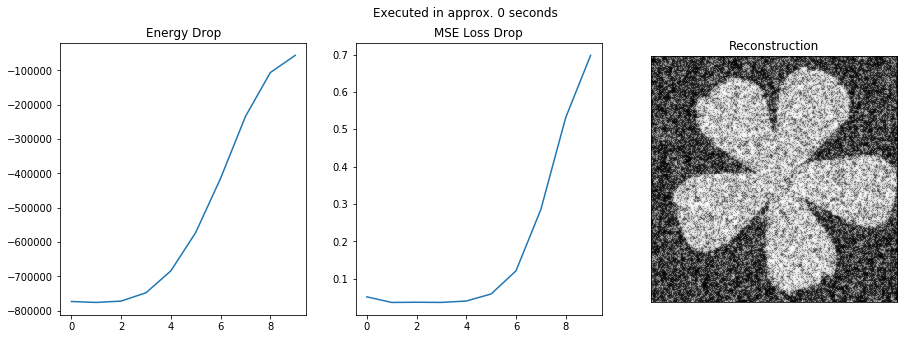

init temp:0.1, final temp:10, lambda:1, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


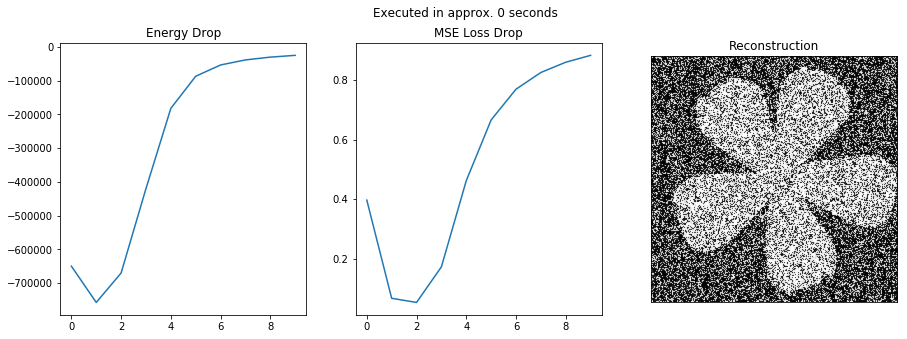

init temp:0.1, final temp:10, lambda:2, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


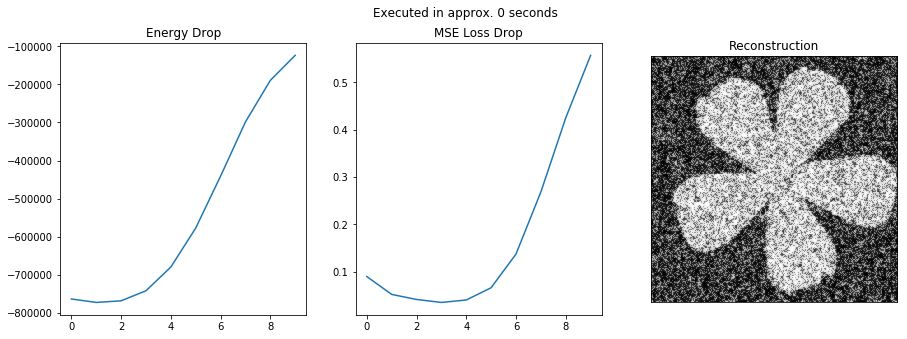

init temp:0.1, final temp:10, lambda:2, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


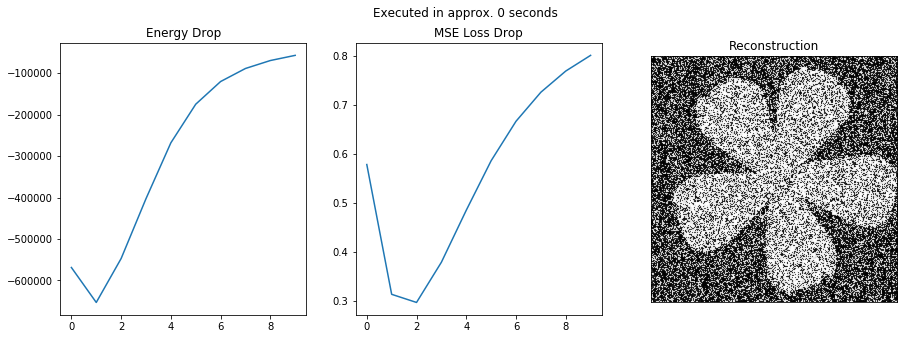

init temp:0.001, final temp:10, lambda:1, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


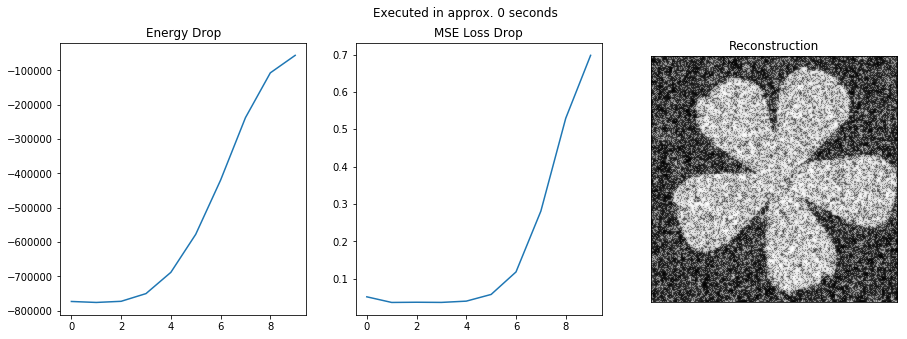

init temp:0.001, final temp:10, lambda:1, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


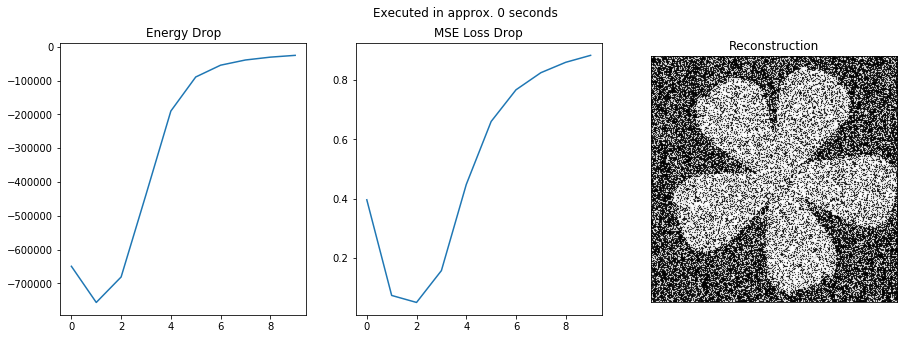

init temp:0.001, final temp:10, lambda:2, kernel:[[1 1 1]
 [1 0 1]
 [1 1 1]]


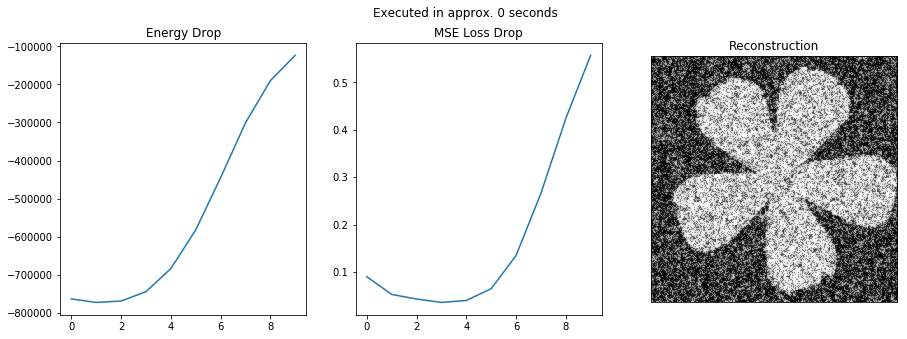

init temp:0.001, final temp:10, lambda:2, kernel:[[0 1 0]
 [1 0 1]
 [0 1 0]]


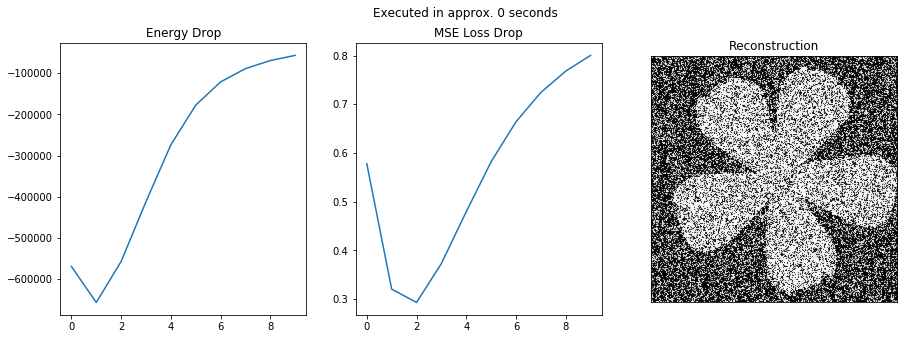

In [21]:
for ti in [1, 10]:
    for tf in [0.1, 0.001]:
        for lamb in [1, 2]:
            for kernel in [np.array([[1,1,1],[1,0,1],[1,1,1]]), np.array([[0,1,0],[1,0,1],[0,1,0]])]:
                kwargs = {'ti': ti, 'tf': tf, 'lamb': lamb, 'kernel': kernel}
                print('init temp:{}, final temp:{}, lambda:{}, kernel:{}'.format(tf, ti, lamb, kernel))
                evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10, **kwargs)

Some observation:
* Optimisation is much better if we consider the 8 neighbouring pixels instead of 4, which makes sense because it is considering more about its neighbours.
* Increasing $\lambda$ seems to worsen the optimisation, which might be because it relies on $h$ (the noisy image) more.
* Using $T=0.1$ or $T=0.01$ as the smallest temperature does not seem to matter, probably because the algorithm has converged anyway, but
* Using $T=1$ as initialisation is much better than $T=10$, which might be because when the algorithm runs from $T=10$ to $T=1$, numeric approximations causes the values to 'collapse', i.e. making all values the same.

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
For this part of the task please use the Wine data set (different one than before, see [4]). It contains three classes, see more detailed description online. Implement both, plain-vanilla k-means and smooth k-means in mean field [1] and compare them on the Wine data set.
</p>

In [22]:
from sklearn.cluster import KMeans

df = pd.read_csv('wine.data')
labels = df.iloc[:, 0]
data = df.iloc[:, 1:]

# km = KMeans(3).fit(data)
# km_labels = km.predict(data)

In [23]:
from scipy.spatial.distance import pdist, cdist, squareform

def km(X, n_clusters):
    """
    Parameters:
    X (np.ndarray): Data matrix, shape (n_data, n_features)
    
    Returns:
    y (np.ndarray): Centroids, shape (n_clusters, n_features)
    q (np.ndarray): Assigments probablity, shape (n_data, n_clusters)
    """
    q = np.zeros((X.shape[0], n_clusters))
    q += 1/n_clusters
    q += np.abs(np.random.normal(scale=0.01, size=q.shape))
    q /= np.sum(q, axis=1)[:, None]
    q *= np.sum(q / X.shape[0], axis=0)
    
    temperature = 1e6
    while temperature > 1e4:
        for _ in range(10):
            prob_y = np.sum(q / X.shape[0], axis=0)
            y = q.T.dot(X) / X.shape[0]
            y /= prob_y[:, None]
            h = cdist(X, y) ** 2  # (N, K)

            q = np.exp(-h/temperature) * prob_y
            q /= np.sum(q, axis=1)[:, None]
        temperature *= 0.7
    return y, q

In [24]:
def kms(X, n_clusters):
    """
    Parameters:
    X (np.ndarray): Data matrix, shape (n_data, n_features)
    
    Returns:
    y (np.ndarray): Centroids, shape (n_clusters, n_features)
    q (np.ndarray): Assigments probablity, shape (n_data, n_clusters)
    """
    q = np.zeros((X.shape[0], n_clusters))
    q += 1/n_clusters
    q += np.abs(np.random.normal(scale=0.01, size=q.shape))
    q /= np.sum(q, axis=1)[:, None]
    q *= np.sum(q / X.shape[0], axis=0)
    
    pd = (squareform(pdist(X)) <= 500).astype(int) - np.eye(X.shape[0], X.shape[0]) # (N, N)
    
    temperature = 1e6
    while temperature > 1e4:
        for _ in range(10):
            prob_y = np.sum(q / X.shape[0], axis=0)
            y = q.T.dot(X) / X.shape[0]
            y /= prob_y[:, None]
            h = cdist(X, y) ** 2  # (N, K)
            
            h = h + 100*pd.dot(np.sum(q, axis=1)[:, None] - q) # (N, K)

            q = np.exp(-h/temperature) * prob_y
            q /= np.sum(q, axis=1)[:, None]
        temperature *= 0.7
    return y, q

In [25]:
km_centroids, km_labels = km(data, 3)
km_labels = np.argmax(km_labels, axis=1)
print(km_labels)
kms_centroids, kms_labels = kms(data, 3)
kms_labels = np.argmax(kms_labels, axis=1)
print(kms_labels)

[1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 1 1 2 1 1 1 1 1 1 2 2 1
 1 2 2 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 0 2 0 2 0 0 2 0 0 2 2 2 0 0 2 2
 0 0 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 2 0 2 0 0 0 2 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 2 2 0 0 0 0 2 0 0 2 2 0 0 2
 0 0 0 0 2 2 2 0 2 2 0 0 2 0 2 0 0 2 2 2 2 0 0 2 2 2 2 2 0]
[1 0 0 2 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 2 2 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1
 1 2 1 1 1 2 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2]


In [26]:
import scipy.optimize
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(km_labels, labels)
r, c = scipy.optimize.linear_sum_assignment(-cm)
print('Acc. of vanilla k-means:', np.sum(cm[r, c]) / np.sum(cm))
cm = confusion_matrix(kms_labels, labels)
r, c = scipy.optimize.linear_sum_assignment(-cm)
print('Acc. of smooth k-means:', np.sum(cm[r, c]) / np.sum(cm))

Acc. of vanilla k-means: 0.672316384180791
Acc. of smooth k-means: 0.5480225988700564


<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.
</p>

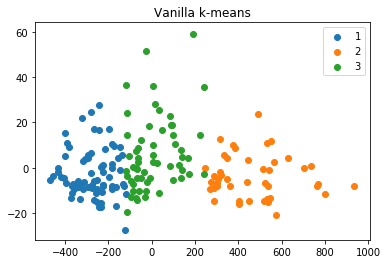

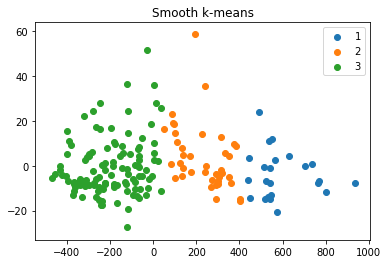

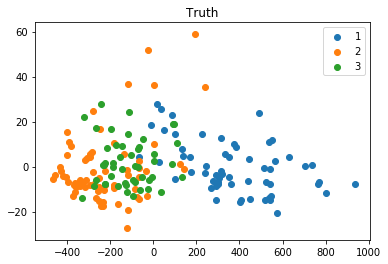

In [27]:
import sklearn.manifold
import sklearn.decomposition
Xt = sklearn.decomposition.PCA().fit_transform(data)
plt.title('Vanilla k-means')
for g in np.unique(km_labels):
    i = np.where(km_labels == g)
    plt.scatter(Xt[i, 0], Xt[i, 1], label=g+1)
plt.legend()
plt.figure()
plt.title('Smooth k-means')
for g in np.unique(kms_labels):
    i = np.where(kms_labels == g)
    plt.scatter(Xt[i, 0], Xt[i, 1], label=g+1)
plt.legend()
plt.figure()
plt.title('Truth')
for g in np.unique(labels):
    i = np.where(labels == g)
    plt.scatter(Xt[i, 0], Xt[i, 1], label=g)
plt.legend()
plt.show()

<p style="background-color:#adebad;">
Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.
</p>

In [28]:
cm = confusion_matrix(km_labels, labels)
print('Purity of vanilla k-means:', np.sum(np.max(cm, axis=0)) / len(labels))
cm = confusion_matrix(kms_labels, labels)
print('Purity of smooth k-means:', np.sum(np.max(cm, axis=0)) / len(labels))

Purity of vanilla k-means: 0.672316384180791
Purity of smooth k-means: 0.7909604519774012


For smooth k-means it is expected that for each data point, points in its neighbourhood should share the same labelling as the said point. While this is true, the accuracy of smooth k-means is worse because it somwhows 'eats' into other clusters while the true labels do not even show a clear division. However, the purity of smooth k-means is unexpectedly better. Looking at the true label plots, we can see points with labels 1 and 3 kind of clash with one another. Smooth k-means kind of take the whole part and consider the whole as label 1 which helps the purity since the true label 1s are basically the subset of the predicted label 1.

<p style="background-color:#adebad;">
Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). Does it indicate 3 clusters? How does the smooth k-means clustering solution change changing the temperature of the mean field approximation?
</p>

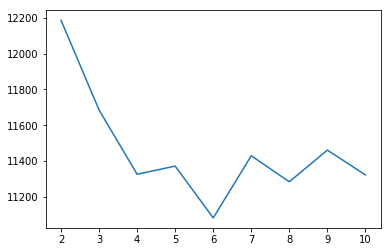

In [29]:
# BIC
def compute_bic(centers, labels, X, m):
    """
    from https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans
    """
    n = np.bincount(labels,minlength=m)+1e-5
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    return -BIC

bic = []

for n_clusters in [2,3,4,5,6,7,8,9,10]:
    kms_centroids, kms_labels = kms(data, n_clusters)
    kms_labels = np.argmax(kms_labels, axis=1)
    bic.append(compute_bic([kms_centroids], kms_labels, data.values, n_clusters))
    
plt.plot([2,3,4,5,6,7,8,9,10], bic)
plt.show()

BIC shows n_cluster=6 is optimal.

[5 5 1 3 1 1 1 5 5 1 1 1 5 1 1 1 5 1 3 3 3 5 5 3 3 5 1 5 5 1 1 5 1 5 5 3 5
 5 3 3 5 5 3 3 5 5 5 5 1 5 1 5 1 5 5 5 1 1 0 3 0 2 0 0 3 0 0 3 3 3 0 0 5 3
 0 0 0 3 0 0 3 2 0 0 0 0 2 3 2 0 0 0 0 0 5 2 0 3 0 3 2 0 0 3 0 0 0 0 3 2 0
 2 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2 0 2 2 3 3 3 0 2 2 2 3 0 2 3 3 0 2 3
 2 0 0 0 3 2 3 0 3 3 2 0 3 2 3 2 0 3 3 3 2 0 0 3 3 3 3 3 2]
[5 5 3 0 3 3 3 5 5 3 3 3 5 3 3 3 5 3 0 0 0 5 5 0 0 5 3 5 5 3 3 5 3 5 5 0 5
 5 0 0 5 5 0 0 5 5 5 5 3 5 3 5 3 5 5 5 3 3 2 0 2 2 2 2 0 2 2 0 0 0 2 2 5 0
 2 2 2 0 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 5 2 2 0 2 0 2 2 2 0 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 0 2 2 0 0 2 2 0
 2 2 2 2 0 0 0 2 0 0 2 2 0 2 0 2 2 0 0 0 2 2 2 0 0 0 0 0 2]


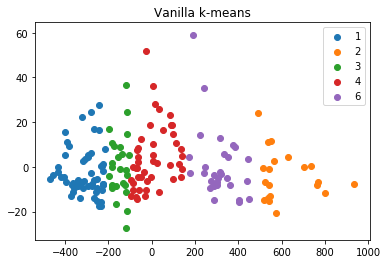

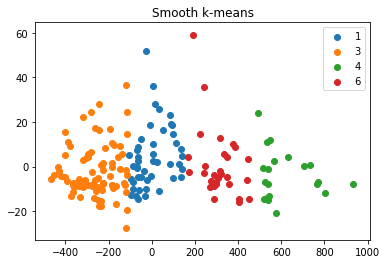

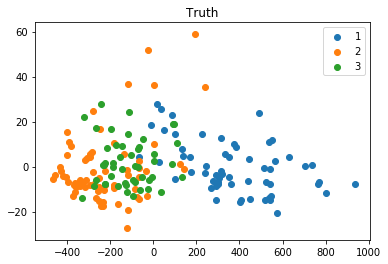

Acc. of vanilla k-means: 0.5254237288135594
Acc. of smooth k-means: 0.5932203389830508
Purity of vanilla k-means: 0.5254237288135594
Purity of smooth k-means: 0.615819209039548


In [30]:
km_centroids, km_labels = km(data, 6)
km_labels = np.argmax(km_labels, axis=1)
print(km_labels)
kms_centroids, kms_labels = kms(data, 6)
kms_labels = np.argmax(kms_labels, axis=1)
print(kms_labels)
Xt = sklearn.decomposition.PCA().fit_transform(data)
plt.title('Vanilla k-means')
for g in np.unique(km_labels):
    i = np.where(km_labels == g)
    plt.scatter(Xt[i, 0], Xt[i, 1], label=g+1)
plt.legend()
plt.figure()
plt.title('Smooth k-means')
for g in np.unique(kms_labels):
    i = np.where(kms_labels == g)
    plt.scatter(Xt[i, 0], Xt[i, 1], label=g+1)
plt.legend()
plt.figure()
plt.title('Truth')
for g in np.unique(labels):
    i = np.where(labels == g)
    plt.scatter(Xt[i, 0], Xt[i, 1], label=g)
plt.legend()
plt.show()
cm = confusion_matrix(km_labels, labels)
r, c = scipy.optimize.linear_sum_assignment(-cm)
print('Acc. of vanilla k-means:', np.sum(cm[r, c]) / np.sum(cm))
cm = confusion_matrix(kms_labels, labels)
r, c = scipy.optimize.linear_sum_assignment(-cm)
print('Acc. of smooth k-means:', np.sum(cm[r, c]) / np.sum(cm))
cm = confusion_matrix(km_labels, labels)
print('Purity of vanilla k-means:', np.sum(np.max(cm, axis=0)) / len(labels))
cm = confusion_matrix(kms_labels, labels)
print('Purity of smooth k-means:', np.sum(np.max(cm, axis=0)) / len(labels))

22508


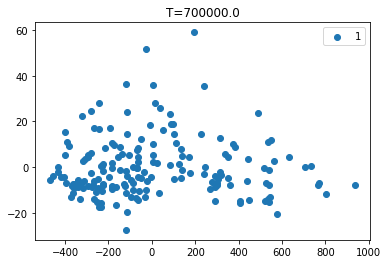

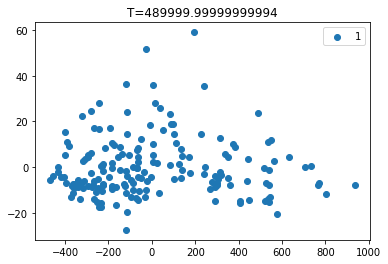

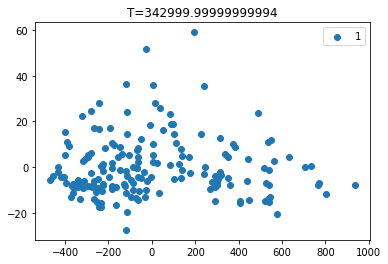

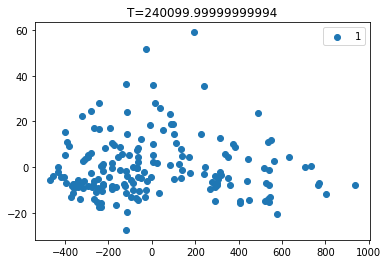

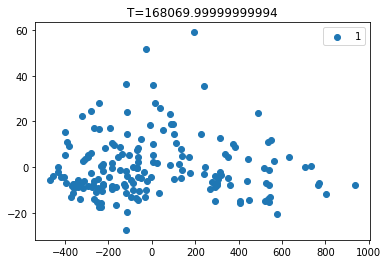

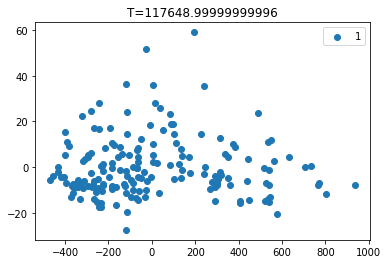

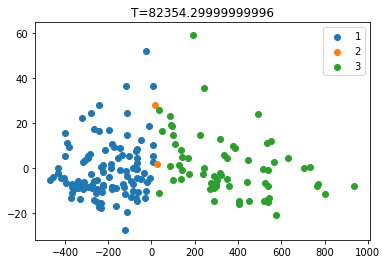

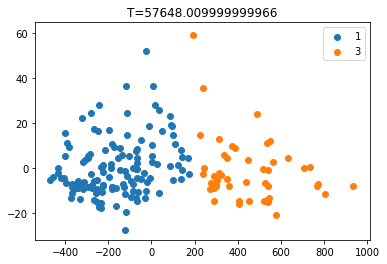

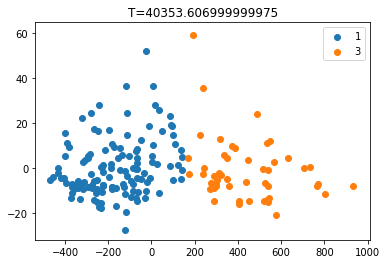

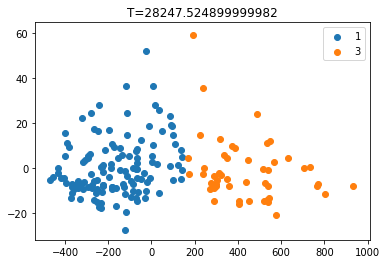

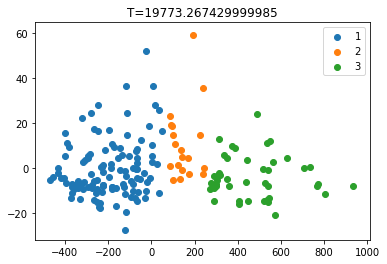

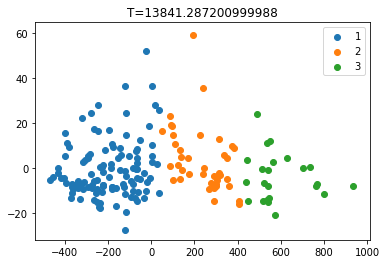

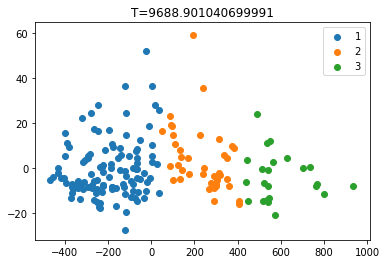

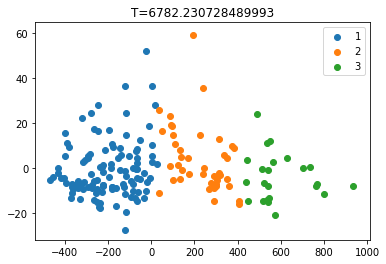

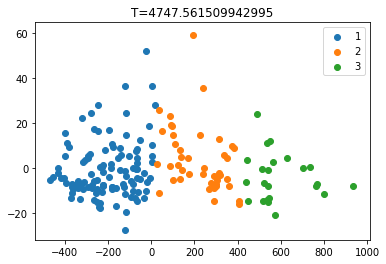

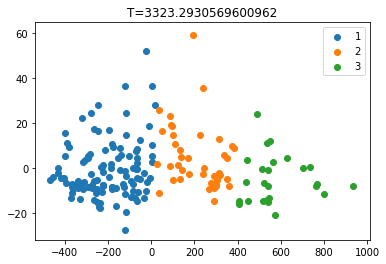

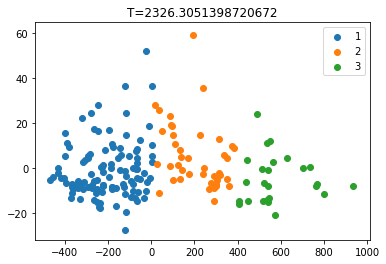

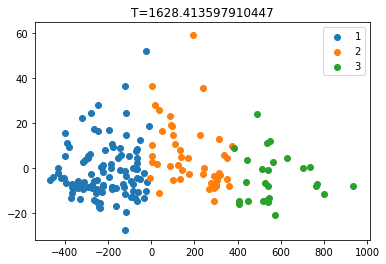

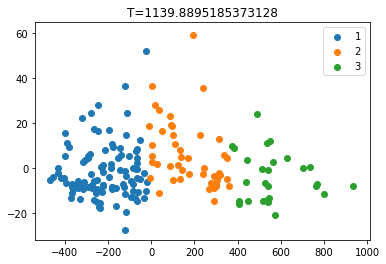

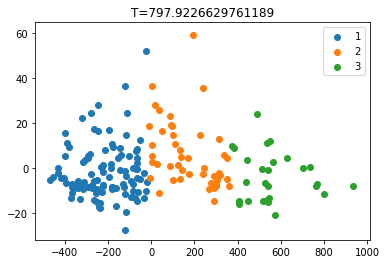

In [31]:
def kms_t(X, n_clusters):
    """
    Parameters:
    X (np.ndarray): Data matrix, shape (n_data, n_features)
    
    Returns:
    y (np.ndarray): Centroids, shape (n_clusters, n_features)
    q (np.ndarray): Assigments probablity, shape (n_data, n_clusters)
    """
    q = np.zeros((X.shape[0], n_clusters))
    q += 1/n_clusters
    q += np.abs(np.random.normal(scale=0.01, size=q.shape))
    q /= np.sum(q, axis=1)[:, None]
    q *= np.sum(q / X.shape[0], axis=0)
    
    pd = (squareform(pdist(X)) <= 500).astype(int) - np.eye(X.shape[0], X.shape[0]) # (N, N)
    print(np.count_nonzero(pd))
    
    temperature = 1e6
    count = 0
    while temperature > 1e3:
        for _ in range(10):
            prob_y = np.sum(q / X.shape[0], axis=0)
            y = q.T.dot(X) / X.shape[0]
            y /= prob_y[:, None]
            h = cdist(X, y) ** 2  # (N, K)
            
            h = h + 100*pd.dot(np.sum(q, axis=1)[:, None] - q) # (N, K)

            q = np.exp(-h/temperature) * prob_y
            q /= np.sum(q, axis=1)[:, None]
        temperature *= 0.7
        
        if count % 1 == 0:
            plt.figure()
            plt.title('T={}'.format(temperature))
            kms_labels = np.argmax(q, axis=1)
            for g in np.unique(kms_labels):
                i = np.where(kms_labels == g)
                plt.scatter(Xt[i, 0], Xt[i, 1], label=g+1)
            plt.legend()
        
        count += 1
kms_t(data, 3)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.